In [1]:
import pandas as pd
from   matplotlib import pyplot as plt
import numpy as np
from   statsmodels.tsa import stattools
import matplotlib
from   sklearn.metrics import mean_absolute_error
from   keras import backend as K
from   keras.layers import *
from   keras.models import *
from   keras.callbacks import *
import pickle

Using TensorFlow backend.


In [2]:
with open('./data/user_features.pickle', 'rb') as handle:
    user_features = pickle.load(handle)

### DEFINE T2V LAYER ###

### CREATE GENERATOR FOR LSTM AND T2V ###

In [3]:
class T2V(Layer):

    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='W', 
                              shape=(self.output_dim, self.output_dim),
                              initializer='uniform',
                              trainable=True)
        
        self.B = self.add_weight(name='B', 
                              shape=(input_shape[1], self.output_dim),
                              initializer='uniform',
                              trainable=True)
        
        self.w = self.add_weight(name='w', 
                              shape=(1, 1),
                              initializer='uniform',
                              trainable=True)
        
        self.b = self.add_weight(name='b', 
                              shape=(input_shape[1], 1),
                              initializer='uniform',
                              trainable=True)
        
        super(T2V, self).build(input_shape)

    def call(self, x):
        original = self.w * x + self.b
        x = K.repeat_elements(x, self.output_dim, -1)
        sin_trans = K.sin(K.dot(x, self.W) + self.B)
        return K.concatenate([sin_trans,original], -1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim+1)

In [4]:
sequence_length = 20

In [5]:
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

### DEFINE MODEL STRUCTURES ###

In [6]:
def T2V_NN(dim, t2v_dim):
    inp = Input(shape=(dim,1))
    x = T2V(t2v_dim)(inp)
    x = LSTM(32)(x)
    x = Dense(1)(x)
    m = Model(inp, x)
    return m

def NN(dim):
    inp = Input(shape=(dim,1))
    x = LSTM(32)(inp)
    x = Dense(1)(x)
    m = Model(inp, x)
    return m

In [7]:
def createData(data,feature):
    
    X, Y = [], []
    for sequence in gen_sequence(data, sequence_length, [feature]):
        X.append(sequence)

    for sequence in gen_labels(data, sequence_length, [feature]):
        Y.append(sequence)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    ### TRAIN TEST SPLIT ###
    
    train_dim = int(0.6*len(data))
    X_train, X_test = X[:train_dim], X[train_dim:]
    y_train, y_test = Y[:train_dim], Y[train_dim:]
    
    return X_train,X_test,y_train,y_test

In [8]:
def train_model(T2V_NN,X_train,y_train,sequence_length):
    nnT2V = T2V_NN(sequence_length, 128)
    nnT2V.compile(loss='mse', optimizer='adam')
    nnT2V.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2, shuffle=True, validation_split=0.2)
    return nnT2V

In [9]:
latent_space = {}

### PREPARE DATA TO FEED MODELS ###

In [10]:
for i in range(1,23):
    if i not in [3,5,16,19]:
        X_train,X_test,y_train,y_test= createData(user_features[i],'avg')
        nnT2V          = train_model(T2V_NN,X_train,y_train,sequence_length)
        pred_t2v_test  = nnT2V.predict(X_test).ravel()
        mean_absolute_error(y_test, pred_t2v_test)
        pred_t2v_train  = nnT2V.predict(X_train).ravel()
        latent_space[i]    = np.concatenate((pred_t2v_train,pred_t2v_test),axis=0)

Train on 48 samples, validate on 13 samples
Epoch 1/100
 - 1s - loss: 81.7517 - val_loss: 70.0704
Epoch 2/100
 - 0s - loss: 64.8005 - val_loss: 56.8569
Epoch 3/100
 - 0s - loss: 53.0072 - val_loss: 47.4043
Epoch 4/100
 - 0s - loss: 42.2917 - val_loss: 34.9929
Epoch 5/100
 - 0s - loss: 31.3421 - val_loss: 27.1469
Epoch 6/100
 - 0s - loss: 24.5372 - val_loss: 21.2728
Epoch 7/100
 - 0s - loss: 19.2595 - val_loss: 16.9254
Epoch 8/100
 - 0s - loss: 15.4309 - val_loss: 13.7359
Epoch 9/100
 - 0s - loss: 12.7166 - val_loss: 11.6700
Epoch 10/100
 - 0s - loss: 10.8928 - val_loss: 10.1128
Epoch 11/100
 - 0s - loss: 9.4561 - val_loss: 8.8114
Epoch 12/100
 - 0s - loss: 8.2089 - val_loss: 7.5881
Epoch 13/100
 - 0s - loss: 7.0195 - val_loss: 6.4797
Epoch 14/100
 - 0s - loss: 6.0181 - val_loss: 5.6154
Epoch 15/100
 - 0s - loss: 5.2347 - val_loss: 4.9258
Epoch 16/100
 - 0s - loss: 4.5960 - val_loss: 4.3413
Epoch 17/100
 - 0s - loss: 4.0470 - val_loss: 3.8293
Epoch 18/100
 - 0s - loss: 3.5651 - val_loss

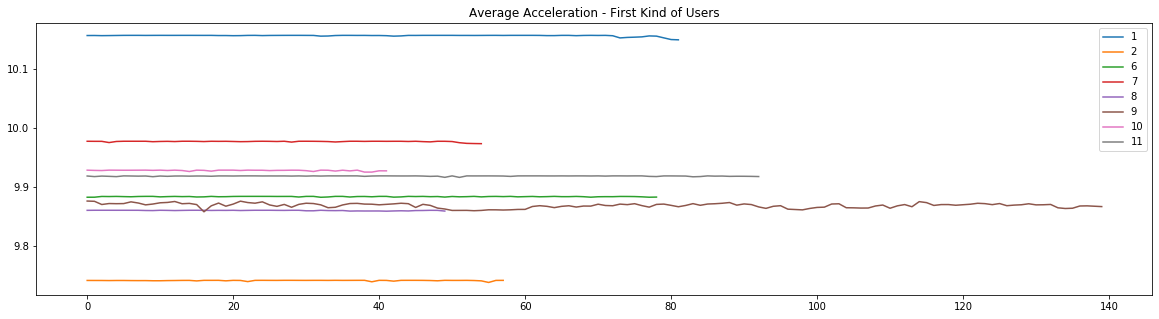

In [14]:
matplotlib.rcParams['figure.figsize'] = (20, 5)
first_users = []
for i in latent_space:
    if i in [1,2,3,5,6,7,8,9,10,11]:
        first_users.append(i)
        plt.plot(latent_space[i])
plt.legend(first_users)
plt.title('Average Acceleration - First Kind of Users')
plt.savefig('avg_acce_first_part_1.png')

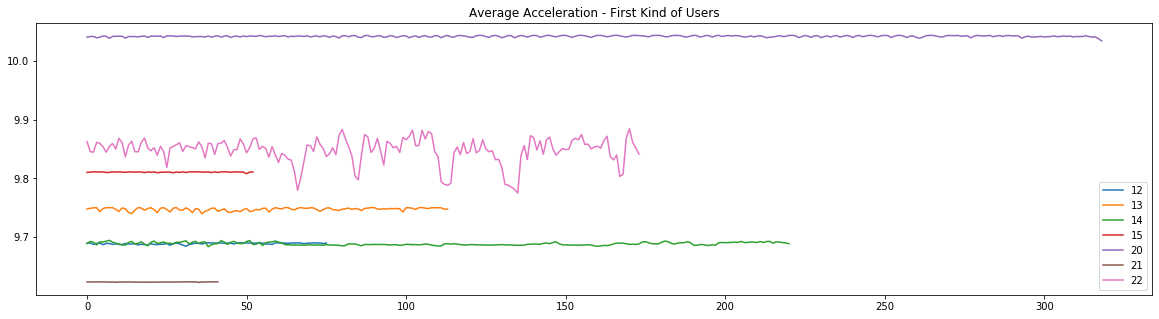

In [13]:
matplotlib.rcParams['figure.figsize'] = (20, 5)
first_users = []
for i in latent_space:
    if i in [12,13,14,15,16,20,21,22]:
        first_users.append(i)
        plt.plot(latent_space[i])
plt.legend(first_users)
plt.title('Average Acceleration - First Kind of Users')
plt.savefig('avg_acce_first_part_2.png')

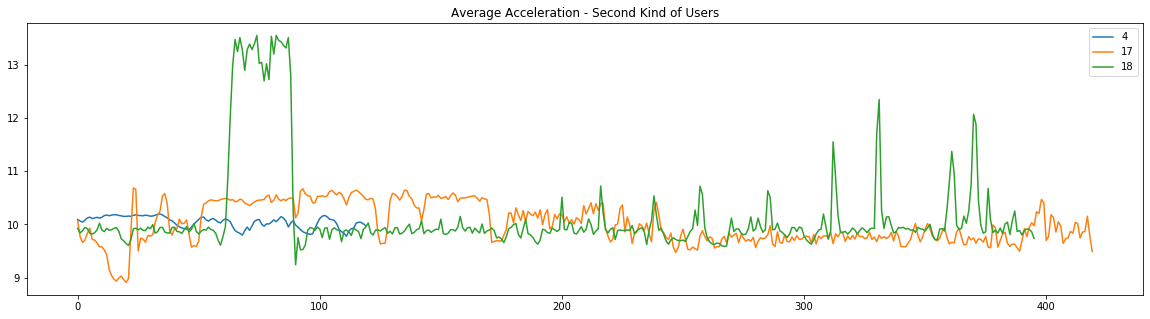

In [16]:
matplotlib.rcParams['figure.figsize'] = (20, 5)
second_users = []
for i in latent_space:
    if i in [4,17,18]:
        second_users.append(i)
        plt.plot(latent_space[i])
plt.legend(second_users)
plt.title('Average Acceleration - Second Kind of Users')
plt.savefig('avg_acce_second.png')